### Library

In [1]:
import os
import re
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.anova import AnovaRM
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

### Load data

### Mixed conditions

In [24]:

# ~~~~~~~~~~~~~~ Parameters
group = 'adult' # 'adult' or 'baby'
modality = 'visual' # 'visual' or 'audio'
subject_lists = ['sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08']
# ~~~~~~~~~~~~~~ Parameters ~~~~~~~~~~~~~~

# final dataframe
df = []

# subject loop
for subject in subject_lists:

    # ~~~~~~~~~~~~~~ Set the working directory
    path = f"/ptmp/kazma/DATA-MINT/data/{group}/processed/{modality}"
    sub_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    sub_folders_sorted = sorted(sub_folders, key=lambda x: int(re.search(r'\d+', x).group())) # Sort the folders based on the numeric part after "sub-"
    # ~~~~~~~~~~~~~~ Set the working directory ~~~~~~~~~~~~~~

    # Get file name
    filename_acc = f"EEGNet_accuracy_all.pkl"
    sub_filename_accuracy = os.path.join(path, subject, filename_acc)

    # Open the file and load data
    with open(sub_filename_accuracy, 'rb') as file:
        data = pickle.load(file)
    data_acc = pd.DataFrame([data])
    df.append(data_acc)


# Concatenate all DataFrames vertically
combined_df = pd.concat(df, ignore_index=True)

# Define column names as shown in the image
column_names = [
    "1 vs. 2",
    "1 vs. 3",
    "1 vs. 4",
    "1 vs. 5",
    "1 vs. 6",
    "2 vs. 3",
    "2 vs. 4",
    "2 vs. 5",
    "2 vs. 6",
    "3 vs. 4",
    "3 vs. 5",
    "3 vs. 6",
    "4 vs. 5",
    "4 vs. 6",
    "5 vs. 6"
]

# Convert column name
combined_df.columns=column_names

df = combined_df.copy()

### Single condition-wise

In [2]:

# ~~~~~~~~~~~~~~ Parameters
group = 'adult' # 'adult' or 'baby'
modality = 'visual' # 'visual' or 'audio'
subject_lists = ['sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08']
target_lists = ['singledot', 'totaldot', 'circum']
# ~~~~~~~~~~~~~~ Parameters ~~~~~~~~~~~~~~

# final dataframe
df = {}

# Condition loop
for target_cond in target_lists:

    x = [] # temporaly dataframe

    # subject loop
    for subject in subject_lists:

        # ~~~~~~~~~~~~~~ Set the working directory
        path = f"/ptmp/kazma/DATA-MINT/data/{group}/processed/{modality}"
        sub_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
        sub_folders_sorted = sorted(sub_folders, key=lambda x: int(re.search(r'\d+', x).group())) # Sort the folders based on the numeric part after "sub-"
        # ~~~~~~~~~~~~~~ Set the working directory ~~~~~~~~~~~~~~

        # Get file name
        filename_acc = f"EEGNet_accuracy_{target_cond}.pkl"
        sub_filename_accuracy = os.path.join(path, subject, filename_acc)

        # Open the file and load data
        with open(sub_filename_accuracy, 'rb') as file:
            data = pickle.load(file)
        data_acc = pd.DataFrame([data])
        x.append(data_acc)

    # Concatenate all DataFrames vertically
    combined_df = pd.concat(x, ignore_index=True)

    # Define column names as shown in the image
    column_names = [
        "1 vs. 2",
        "1 vs. 3",
        "1 vs. 4",
        "1 vs. 5",
        "1 vs. 6",
        "2 vs. 3",
        "2 vs. 4",
        "2 vs. 5",
        "2 vs. 6",
        "3 vs. 4",
        "3 vs. 5",
        "3 vs. 6",
        "4 vs. 5",
        "4 vs. 6",
        "5 vs. 6"
    ]

    # Convert column name
    combined_df.columns=column_names

    # final dataframe
    df[target_cond] = combined_df

### Pick the target condition's data

In [25]:
condition = 'all' # ['singledot', 'totaldot', 'circum'], 'all'
if condition == 'all':
    x = df.copy()
else:
    x = df[condition]
x = x.iloc[:,:5] # only first five conditions = 1 vs. 2, 3, 4, 5, 6

print("===========================================")
print(f"==============  {condition}  =================")
print("===========================================")

==============  all  =================


### Normality Check: Shapiro-Wilk test

In [26]:
# Perform normality test for each condition
column_names = x.columns.tolist()
for i, cond in enumerate(column_names):  # Loop over each condition
    stat, p = stats.shapiro(x[cond])  # Shapiro-Wilk test
    print(f"{cond}: W={stat:.3f}, p={p:.4f}")

    # Interpretation
    if p > 0.05:
        print("  Data looks normally distributed ✅")
    else:
        print("  Data is NOT normally distributed ❌ (consider non-parametric test)")

    print("------------------------------------------")

1 vs. 2: W=0.878, p=0.2613
  Data looks normally distributed ✅
------------------------------------------
1 vs. 3: W=0.941, p=0.6681
  Data looks normally distributed ✅
------------------------------------------
1 vs. 4: W=0.931, p=0.5891
  Data looks normally distributed ✅
------------------------------------------
1 vs. 5: W=0.816, p=0.0807
  Data looks normally distributed ✅
------------------------------------------
1 vs. 6: W=0.889, p=0.3130
  Data looks normally distributed ✅
------------------------------------------


### One sample t-test against zero: FDR correction

In [27]:

# Perform one-sample t-test against 0.5
t_stats, p_values = stats.ttest_1samp(x, popmean=0.5, axis=0)

# Apply multiple comparisons correction (e.g., Bonferroni or FDR)
corrected_p = multipletests(p_values, method='fdr_bh')[1]  # FDR correction

for i, cond in enumerate(column_names):  # Loop over each condition
    print(f"{cond}: t={t_stats[i]:.3f}, p={corrected_p[i]:.4f}")
    # Interpretation
    if corrected_p[i] < 0.05:
        print("  significant decoding accuracy ✅")
    else:
        print("  non-significant decoding accuracy ❌")
    
    print("------------------------------------------")
    

1 vs. 2: t=2.228, p=0.0764
  non-significant decoding accuracy ❌
------------------------------------------
1 vs. 3: t=4.373, p=0.0120
  significant decoding accuracy ✅
------------------------------------------
1 vs. 4: t=3.812, p=0.0156
  significant decoding accuracy ✅
------------------------------------------
1 vs. 5: t=4.844, p=0.0117
  significant decoding accuracy ✅
------------------------------------------
1 vs. 6: t=4.972, p=0.0117
  significant decoding accuracy ✅
------------------------------------------


### Linear Mixed Effects Model (LMM)

In [28]:
xx = x.copy()
xx['Subject'] = subject_lists
x_long = pd.melt(xx, id_vars='Subject', var_name="Condition", value_name="Score")

# Fit the Linear Mixed Effects Model
model = smf.mixedlm("Score ~ Condition", x_long, groups=x_long["Subject"]).fit()

# Print the model summary
print(model.summary())
# print(model.random_effects)
# print(model.fittedvalues[0:5])

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    Score  
No. Observations:    30         Method:                REML   
No. Groups:          6          Scale:                 0.0004 
Min. group size:     5          Log-Likelihood:        48.2030
Max. group size:     5          Converged:             Yes    
Mean group size:     5.0                                      
--------------------------------------------------------------
                     Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.538    0.023 22.966 0.000  0.492  0.584
Condition[T.1 vs. 3] 0.048    0.012  4.009 0.000  0.024  0.071
Condition[T.1 vs. 4] 0.064    0.012  5.408 0.000  0.041  0.088
Condition[T.1 vs. 5] 0.080    0.012  6.685 0.000  0.056  0.103
Condition[T.1 vs. 6] 0.098    0.012  8.206 0.000  0.074  0.121
Group Var            0.003    0.101                           



/viper/ptmp/kazma/miniforge3/envs/MINT/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Plots

### Mean and SD

/tmp/ipykernel_321627/1048104599.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=df_melted, x="Condition", y="Score", capsize=0, markers="o", linestyles="-", alpha=0.8,


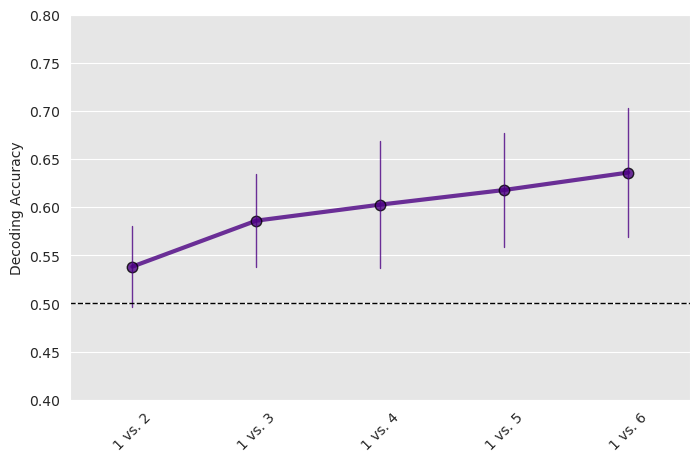

In [29]:
# Convert DataFrame to long format for Seaborn
df_melted = x.melt(var_name="Condition", value_name="Score")

plt.figure(figsize=(8,5))
sns.pointplot(data=df_melted, x="Condition", y="Score", capsize=0, markers="o", linestyles="-", alpha=0.8, 
              linewidth=3, errorbar=("sd", 1), errwidth=1, color="indigo",
              markeredgewidth=1, markeredgecolor='black')

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# Customize plot
plt.ylim(0.40,0.8)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.ylabel("Decoding Accuracy")
plt.xlabel("")
plt.xticks(rotation=45)  # Rotate column labels if needed

# save the plot
figname = f"EEGNet_decoding_{condition}.png"
#
plt.savefig(f"{path}/{figname}", dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

### Model validation: correlation

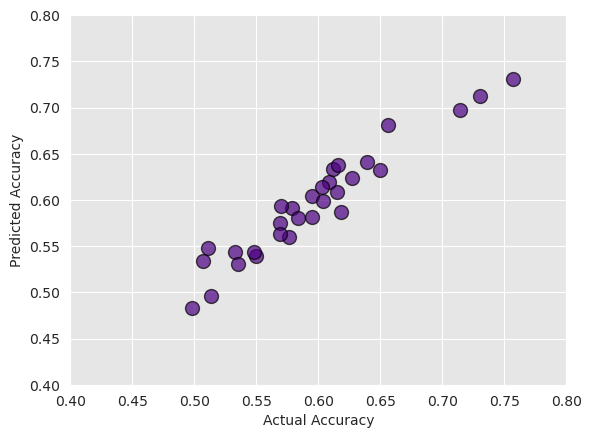

------------------------------------------
all: r=0.962, p=0.0000
  significant correlation coefficients ✅


In [30]:
y = model.fittedvalues  # Predicted values (dependent variable)

plt.scatter(x_long["Score"], y, alpha=0.7, color='indigo',s=100,edgecolor="black", linewidth=1)          


sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.xlabel("Actual Accuracy")
plt.ylabel("Predicted Accuracy")
plt.xlim(0.4, 0.8)
plt.ylim(0.4, 0.8)

# save the plot
figname = f"EEGNet_corr_{condition}.png"
#
plt.savefig(f"{path}/{figname}", dpi=300, bbox_inches='tight')

plt.show()

# Pearson correlation
correlation, p_value = pearsonr(x_long["Score"], y)

print("------------------------------------------")
print(f"{condition}: r={correlation:.3f}, p={p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("  significant correlation coefficients ✅")
else:
    print("  non-significant correlation coefficients ❌")
